The goal of this pre-processing file is to determine what filter and parameters are most likely to make it easier to segment the dataset

In [2]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os

# mount drive- following tutorial at https://medium.com/ml-book/simplest-way-to-open-files-from-google-drive-in-google-colab-fae14810674
from google.colab import drive
drive.mount('/content/drive')
 


Mounted at /content/drive


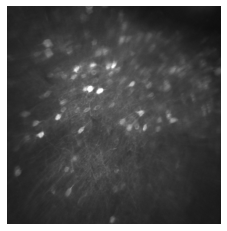

In [3]:
# import image

im_dir='drive/My Drive/CHEME 599/Project/images'; # image path to open
fname='PL01_day1.tif'
  
im=plt.imread(os.path.join(im_dir, fname)); # read image 

fig, ax=plt.subplots(figsize=(4,4)) # prepare plot of image
ax.imshow(im.astype('uint8'))  # plot the image
ax.axis('off'); # remove axis labels, semicolon suppresses text output 

In [4]:
from skimage import color
im=color.rgb2gray(im) 
print(im.shape)

(506, 496)


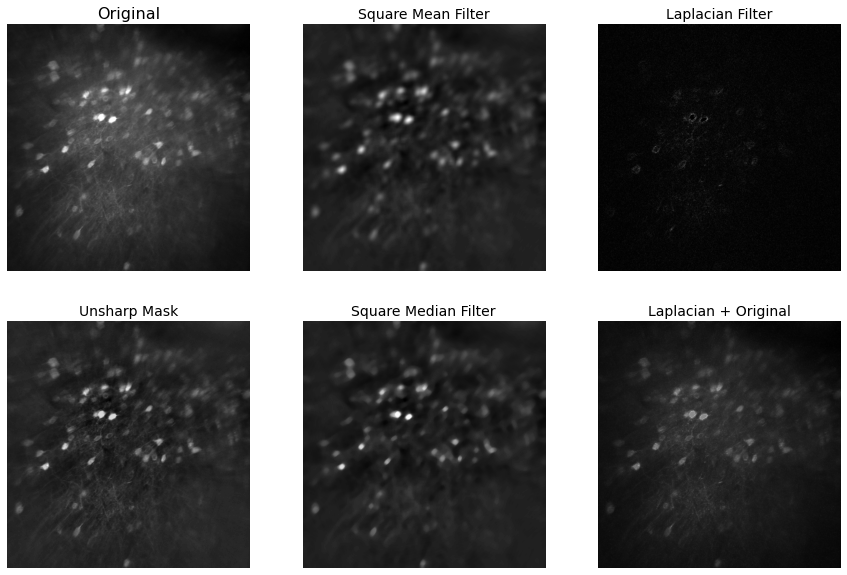

In [9]:
# test spatial filters
from skimage.morphology import square, disk, star
from skimage.filters import rank
from skimage.util import img_as_float, img_as_ubyte
from skimage.filters import laplace

def unsharp_mask(im):  
    from skimage.filters import rank
    from skimage.util import img_as_ubyte
    im=img_as_ubyte(im)
    selem2=square(100)
    background=1.0*rank.mean(im, selem2)
    im_us=im-background
  
    imin = np.min(im_us) #custom rescaling
    imax = np.max(im_us)
    full = imax - imin
    im_us = np.round(255*(im_us - imin)/full, 0)
    return(im_us)

im_us=unsharp_mask(im)
im=img_as_ubyte(im)
selem=square(10) # make a 10x10 square of ones 
im_mean=unsharp_mask(rank.mean(im, selem=selem)) # create image filtered with square mean spatial filter
im_med=unsharp_mask(rank.median(im, selem=selem)) # create image filtered with square median spatial filter 

im_lap=laplace(im, ksize=3) # create structural element for laplacian filter
im_lap=np.abs(im_lap) # take absolute value of edge image-- just want edges not direction 
lap_plus=img_as_float(im)+im_lap; # add the laplacian filtered image to the image to sharpen edges



fig, ax=plt.subplots(figsize=(15, 10) , ncols=3, nrows=2)


ax[0,0].imshow(im, cmap='gray')
ax[0,0].set_title('Original',fontsize=16)
ax[0,0].axis('off')

ax[1,0].imshow(im_us, cmap='gray')
ax[1,0].set_title('Unsharp Mask', fontsize=14)
ax[1,0].axis('off');

ax[0,1].imshow(im_mean, cmap='gray')
ax[0,1].set_title('Square Mean Filter',fontsize=14)
ax[0,1].axis('off')

ax[1,1].imshow(im_med, cmap='gray')
ax[1,1].set_title('Square Median Filter', fontsize=14)
ax[1,1].axis('off');

ax[0,2].imshow(im_lap, cmap='gray')
ax[0,2].set_title('Laplacian Filter',fontsize=14)
ax[0,2].axis('off')

ax[1,2].imshow(lap_plus, cmap='gray')
ax[1,2].set_title('Laplacian + Original', fontsize=14)
ax[1,2].axis('off');



In [18]:
def frequency_filter(im,filt): # general function to perform filtering in the frequency domain 
  import scipy as sp # needed for fft
  # perform fft 
  im=img_as_float(im)
  f_im=sp.fft.fft2(im)
  # center
  f_im2=sp.fft.fftshift(f_im)
  #multiply by a filter function
  f_im3=np.multiply(f_im2, filt) 
  #un-center
  f_im4=sp.fft.ifftshift(f_im3)
  # perform inverse fft
  im_fft=np.real(sp.fft.ifft2(f_im4)) # possible to have imaginary component-- use real to remove this
  return im_fft

def gaussian_filter(im,divisor):
  xi=np.linspace(0,im.shape[1]-1,im.shape[1])
  yi=np.linspace(0,im.shape[0]-1,im.shape[0])
  x,y=np.meshgrid(xi,yi) # need to make sure filter is same shape as image
  mu1, mu2, sigmaHi, sigmaLo= im.shape[1]/2, im.shape[0]/2, im.shape[1]/divisor, im.shape[1]/divisor # bigger sigma = bigger
  gfilt=np.exp(-((x-mu1)**2+(y-mu2)**2)/(2*sigmaHi**2)) # remove high frequency 
  gfilt2=1-np.exp(-((x-mu1)**2+(y-mu2)**2)/(2*sigmaLo**2)) # remove low frequency 
  
  imHi=frequency_filter(im, gfilt2)
  imLo=frequency_filter(im, gfilt)

  fig, ax=plt.subplots(figsize=(10, 10) , ncols=2)
  ax[0].imshow(imHi,cmap='gray')
  ax[0].axis('off')
  ax[0].set_title('High Pass Filtered Image')
  ax[1].imshow(imLo,cmap='gray')
  ax[1].axis('off')
  ax[1].set_title('Low Pass Filtered Image')
  
  return imHi, imLo

def butterwoth_filter(im, order, D0, hipass):
  n, D0= order, D0
  xi=np.linspace(0,im.shape[1]-1,im.shape[1])
  yi=np.linspace(0,im.shape[0]-1,im.shape[0])
  x,y=np.meshgrid(xi,yi) # need to make sure filter is same shape as image
  D=np.sqrt((x-im.shape[1]/2)**2+(y-im.shape[0]/2)**2)
  if hipass==0:
    bfilt=1-1/(1+(D/D0)**(2*n))
  else:
    bfilt=1/(1+(D/D0)**(2*n))
  
  imB=frequency_filter(im, bfilt)
  fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
  ax.imshow(imB, cmap='gray')
  ax.set_title('Butterworth Filtered Image')
  ax.axis('off')

  return imB

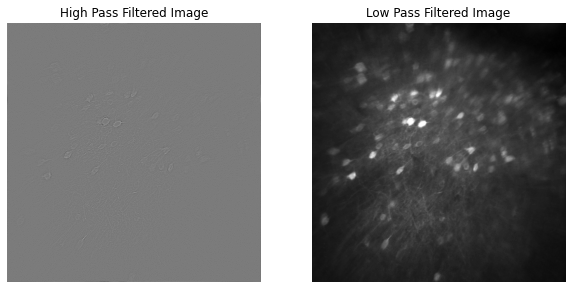

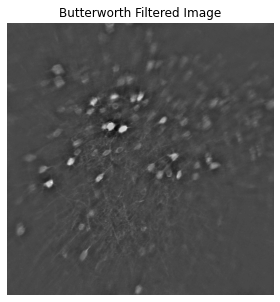

In [19]:

(imHi, imLo)=gaussian_filter(im, 2)
imB=butterwoth_filter(im_us, 2, 10, 0)